In [2]:
import os
import shutil
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
dataset_path = "./archive" #inputs: Données existants
output_path = "./sorted_by_emotion" #outputs
os.makedirs(output_path, exist_ok=True)

**1) Organisation des données par émotion.**

In [4]:
# Les émotions possibles
emotion_map = {
    "01": "neutre",
    "02": "calme",
    "03": "heureux",
    "04": "triste",
    "05": "colère",
    "06": "peur",
    "07": "dégoût",
    "08": "surprise"
}

In [5]:
# Parcours de tous les sous-dossiers et fichiers
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split("-")
            emotion_code = parts[2]
            emotion_name = emotion_map.get(emotion_code, "inconnu")

            # 📁 Crée un dossier pour chaque émotion
            emotion_folder = os.path.join(output_path, emotion_name)
            os.makedirs(emotion_folder, exist_ok=True)

            # 📤 Copie le fichier audio dans le bon dossier
            source_file = os.path.join(root, file)
            dest_file = os.path.join(emotion_folder, file)
            shutil.copy(source_file, dest_file)

print("✅ Fichiers copiés et organisés par émotion dans :", output_path)

✅ Fichiers copiés et organisés par émotion dans : ./sorted_by_emotion


**2) Prétraitement des données audio**

In [6]:
# 📁 Dossier contenant les fichiers triés par émotion
data_path = "./sorted_by_emotion"

# 📦 Données finales
X = []  # features
y = []  # labels (émotions)

# 🔁 Parcours de chaque dossier d’émotion
for emotion_label in os.listdir(data_path):
    emotion_folder = os.path.join(data_path, emotion_label)
    if not os.path.isdir(emotion_folder):
        continue

    # Parcours des fichiers .wav
    for file in os.listdir(emotion_folder):
        if file.endswith(".wav"):
            file_path = os.path.join(emotion_folder, file)

            # 🔊 Charger l'audio
            audio, sr = librosa.load(file_path, sr=22050)

            # 🎯 Extraire les MFCCs
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

            # 🔁 S'assurer que toutes les séquences ont la même longueur
            mfcc = librosa.util.fix_length(mfcc, size=174, axis=1)  # (40, 174)

            # Ajouter à la liste
            X.append(mfcc)
            y.append(emotion_label)

# 📐 Convertir en tableaux numpy
X = np.array(X)
y = np.array(y)

print("✅ MFCCs extraits :", X.shape)
print("✅ Labels extraits :", y.shape)


✅ MFCCs extraits : (1440, 40, 174)
✅ Labels extraits : (1440,)


**3) Encoder les labels (émotions) en format numérique**

In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Labels encodés :", y_encoded[:10])
print("Classes :", le.classes_)

Labels encodés : [6 6 6 6 6 6 6 6 6 6]
Classes : ['calme' 'colère' 'dégoût' 'heureux' 'neutre' 'peur' 'surprise' 'triste']


**4) Préparation des données pour le modèle**

In [8]:
X = X[..., np.newaxis]
print("Nouvelle forme de X :", X.shape)

Nouvelle forme de X : (1440, 40, 174, 1)


**5) Séparation en train/test**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

**6) Construire un modèle simple CNN avec TensorFlow/Keras**

In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40, 174, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')  # nombre de classes = nb émotions
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 172, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 42, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 21504)             0         
                                                                 
 dense (Dense)               (None, 128)               2

**7) Entraînement du modèle**

In [11]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
36/36 [==============================] - 3s 79ms/step - loss: 8.1019 - accuracy: 0.1450 - val_loss: 2.0156 - val_accuracy: 0.1736
Epoch 2/30
36/36 [==============================] - 3s 74ms/step - loss: 2.0158 - accuracy: 0.2031 - val_loss: 1.9058 - val_accuracy: 0.2535
Epoch 3/30
36/36 [==============================] - 3s 73ms/step - loss: 1.7390 - accuracy: 0.3385 - val_loss: 1.8067 - val_accuracy: 0.3194
Epoch 4/30
36/36 [==============================] - 3s 72ms/step - loss: 1.2492 - accuracy: 0.5703 - val_loss: 1.5497 - val_accuracy: 0.4236
Epoch 5/30
36/36 [==============================] - 3s 74ms/step - loss: 0.7353 - accuracy: 0.7509 - val_loss: 1.3711 - val_accuracy: 0.5104
Epoch 6/30
36/36 [==============================] - 3s 71ms/step - loss: 0.3921 - accuracy: 0.8655 - val_loss: 1.4461 - val_accuracy: 0.5278
Epoch 7/30
36/36 [==============================] - 3s 71ms/step - loss: 0.2499 - accuracy: 0.9193 - val_loss: 1.5570 - val_accuracy: 0.5278
Epoch 8/30
36

**8) Évaluation et visualisation**

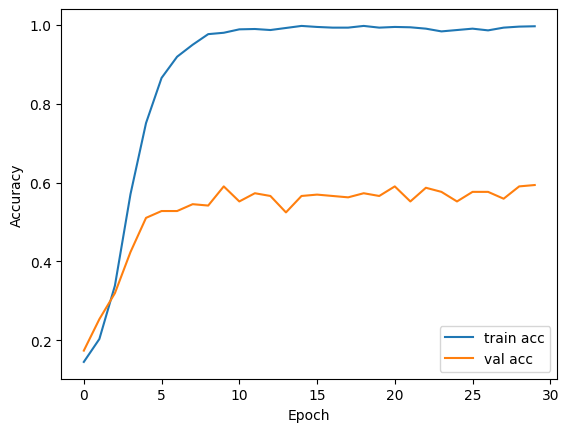

In [12]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

9/9 [==============================] - 0s 22ms/step


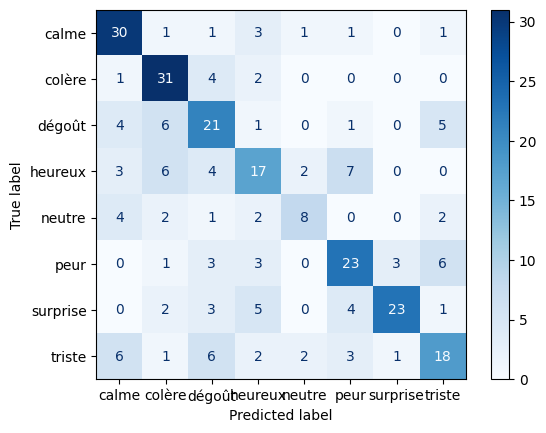

In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**9) Test avec un fichier audio indépendant**

In [14]:
def predict_emotion(file_path):
    audio, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfcc = librosa.util.fix_length(mfcc, size=174, axis=1)
    mfcc = mfcc[np.newaxis, ..., np.newaxis]
    pred = model.predict(mfcc)
    emotion = le.classes_[np.argmax(pred)]
    return emotion

In [30]:
print("Prédiction pour un fichier audio d'exemple :")
example_file = "./sorted_by_emotion/heureux/03-01-03-01-01-01-01.wav"
print("Fichier :", example_file)
print("Émotion prédite :", predict_emotion(example_file))
# Sauvegarder le modèle
model.save('emotion_recognition_model.h5')
print("✅ Modèle sauvegardé sous 'emotion_recognition_model.h5'")
# Nettoyage des fichiers temporaires
shutil.rmtree(output_path)
print("✅ Dossier temporaire supprimé :", output_path)
# Fin du script